#  Implement Workflow Patterns with LangGraph

Estimated time needed: **45** minutes

## Introduction
In this lab, you'll master the three essential workflow patterns that transform individual AI models into sophisticated, coordinated systems. Through hands-on projects using LangGraph and LangChain, you'll build job application assistants, intelligent task routers, and multilingual processors that demonstrate real-world multi-agent coordination.
These proven patterns - Sequential Agent Coordination, Intent-Based Routing, and Parallel Agent Execution - form the foundation of every enterprise AI system. By the end, you'll have the architectural knowledge to create AI applications that intelligently orchestrate multiple specialized agents to solve complex problems.


## __Table of Contents__

<ol>
    <li><a href="#Prompt-Chaining">Prompt Chaining</a></li>
    <li><a href="#Resume-Summary-Agent">Resume Summary Agent</a></li>
    <li><a href="#Generate-Cover-Letter-Agent">Generate Cover Letter Agent</a></li>
    <li><a href="#LangGraph-Workflow">LangGraph Workflow</a></li>
    <li><a href="#Initializing-the-LangGraph-Workflow">Initializing the LangGraph Workflow</a></li>
    <li><a href="#Workflow-Pattern:-Routing">Workflow Pattern: Routing</a></li>
    <li><a href="#Workflow-Pattern:-Parallelization">Workflow Pattern: Parallelization</a></li>
    </ol>

<a href="#Exercises:-Building-a-Multi-Agent-Routing-System">Exercises: Building a Multi-Agent Routing System</a>




In [62]:
%%capture
!pip install langchain-openai==0.3.27
!pip install langgraph==0.6.6
!pip install pygraphviz==1.14
"""
import os
os.kill(os.getpid(), 9)

"""

In [63]:
from langgraph.graph import StateGraph, END,START
from typing import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [64]:
def print_workflow_info(workflow, app=None):
    """Prints comprehensive information about a LangGraph workflow."""
    print("WORKFLOW INFORMATION")
    print("====================")
    print(f"Nodes: {workflow.nodes}")
    print(f"Edges: {workflow.edges}")


    # Use getter method for finish points if available
    try:
        finish_points = workflow.finish_points
        print(f"Finish points: {finish_points}")
    except:
        try:
            # Alternative approaches
            print(f"Finish point: {workflow._finish_point}")
        except:
            print("Finish points attribute not directly accessible")

    if app:
        print("\nWorkflow Visualization:")
        from IPython.display import display
        display(app.get_graph().draw_png())


Now we are going to instantiate the `ChatOpenAI` class with the `gpt-4o-mini` model. This instance, stored in the variable `llm`, will be used to handle all LLM-based interactions throughout our workflows.


In [65]:
llm = ChatOpenAI(model="gpt-4o-mini")

### Prompt Chaining

Prompt Chaining is a workflow design pattern where complex tasks are decomposed into a sequence of LLM (Large Language Model) calls. Each step depends on the output of the previous one, allowing for step-by-step refinement or evolution of the data being processed. This method mirrors how humans tackle multifaceted problems—by breaking them down into manageable steps.

It leverages **function calling**, **sequential chaining** and or **AI Agents** , often implemented using frameworks such as **LangChain**, **LangGraph**, or even custom scripts. The key is modularity and clarity—each node (or step) has a specific role in the overall pipeline. Each link in the chain is a tool call or Agent the structure of which is something like the following:

#### Typical Structure:
- **Step 1:** Initial LLM prompt (for example, generate a draft)
- **Step 2:** Refinement prompt (for example, improve style, tone)
- **Step 3:** Evaluation or formatting (for example, convert to specific format or assess quality)

This pattern also allows injecting **external tools** between steps (for example, validation, summarization, keyword extraction).

---

#### Use Cases:
- Generating blog posts or marketing copy step-by-step (idea → outline → paragraph → polish)
- Automated report generation (for example, extract → analyze → summarize)
- Educational content creation (for example, topic → questions → answers → explanations)

---


### Use Case: Prompt Chaining — Job Application Assistant

In this workflow, we are going to build a simple **job application assistant** using the Prompt Chaining pattern. The goal is to help a user create a **personalized cover letter** from a given job description.

We will break the task into two sequential steps:
1. First, the LLM will read the **job description** and generate a **resume summary** tailored to that role.
2. Then, using this summary, the LLM will generate a professional **cover letter** suitable for submitting with a job application.


For this workflow, we need a structured way to manage the data passed between each step. To achieve this, we define a `ChainState` using `TypedDict`. This state will act as a shared container for all intermediate and final outputs.

- First, we have `job_description`, which will store the input provided by the user, typically a job posting or role summary.
- Then, we include `resume_summary`, which will hold the tailored summary of the applicant’s profile generated by the LLM based on the job description.
- Finally, we have `cover_letter`, where the personalized cover letter will be stored after the second LLM call completes.


In [66]:
class ChainState(TypedDict):
    job_description: str
    resume_summary: str
    cover_letter: str

We can represent an instance of the ChainState class as a Python dictionary. In the Prompt Chaining pattern, here's how the state evolves:
```python

state = {
    "job_description": "",
    "resume_summary": "",
    "cover_letter": ""
}
```
```Initial State```: The workflow begins with a dictionary containing only the job description:

```python
state = {
    "job_description": ""We are looking for a data scientist with experience in machine learning, NLP..",
    "resume_summary": "",
    "cover_letter": ""
}
```

The  next state is given by:
```python
state = {
    "job_description": ""We are looking for a data scientist with experience in machine learning, NLP..",
    "resume_summary": "Results-driven data scientist with expertise in machine learning...",
    "cover_letter": ""
}
```
and so on.


Now, let's see how to build a prompt chain using a series of LLM calls—as in, agents. We'll demonstrate the process, which is summarized in the following image. The input is a state variable containing the job description. This is first passed to the Resume Summary agent, which generates a summary of the resume and stores it under the key resume_summary. That output is then used as input for the Generate Cover Letter agent, which produces a cover letter and fills in the key cover_letter.
![Screenshot 2025-04-24 at 12.03.31 PM.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hseuyL5ddwU6cvKXrVGQnw/Screenshot%202025-04-24%20at%2012-03-31%E2%80%AFPM.png)


### Resume Summary Agent

In LLM workflows, an "agent" is created through a prompt that gives the LLM specific instructions and persona. The generate_resume_summary node demonstrates this by transforming the LLM into a "resume assistant" through its prompt. This node receives the state containing the job description, processes it using the agent created by the prompt, and returns an updated state with the new resume summary.
Nodes provide the workflow structure while prompts define agent capabilities. The state object serves as shared memory between nodes, allowing each agent to build upon previous work while using the same underlying LLM instance.


In [67]:
def generate_resume_summary(state: ChainState) -> ChainState:
    prompt = f"""
You're a resume assistant. Read the following job description and summarize the key qualifications and experience the ideal candidate should have, phrased as if from the perspective of a strong applicant's resume summary.

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "resume_summary": response.content}

The agent starts with this initial state and passes it to the first node, generate_resume_summary. Inside that function, it can access the job description using ```state['job_description']```, which will serve as the input later on.

When the function returns, it uses Python’s dictionary unpacking syntax: **state**. This means “create a new dictionary that includes all the key-value pairs from the original state dictionary, and then add or update specific keys.” In this case, it updates the "resume_summary" field with the newly generated content.
The state varable would look like this:

```python
state = {
    "job_description": ""We are looking for a data scientist with experience in machine learning, NLP..",
    "resume_summary": "Results-driven data scientist with expertise in machine learning...",
    "cover_letter": ""
}
```


### Generate Cover Letter Agent


The ```generate_cover_letter``` node defines our second agent in the workflow. This function creates a specialized agent through its prompt This agent accesses both ```state['resume_summary']``` and ```state['job_description'] ```from the current state, leveraging both the output from the previous agent and the original input. The prompt transforms the LLM into a cover letter specialist that synthesizes these elements into a tailored application document. The agent's output is then added to the state dictionary under the ```cover_letter``` key, completing the workflow chain with a state object containing all three key elements.


In [68]:
def generate_cover_letter(state: ChainState) -> ChainState:
    prompt = f"""
You're a cover letter writing assistant. Using the resume summary below, write a professional and personalized cover letter for the following job.

Resume Summary:
{state['resume_summary']}

Job Description:
{state['job_description']}
"""

    response = llm.invoke(prompt)

    return {**state, "cover_letter": response.content}

## LangGraph Workflow
### Initializing the LangGraph Workflow



This line creates a new `StateGraph` instance and configures it with our `ChainState` definition. This crucial step establishes the workflow's foundation by specifying the structure of data that will flow through the nodes. The `StateGraph` uses the `ChainState` TypedDict to validate data types for each field (`job_description`, `resume_summary`, and `cover_letter`), ensuring proper information passing between nodes. This data contract enables LangGraph to manage state transitions efficiently as the workflow progresses from node to node.


In [69]:
workflow = StateGraph(ChainState)
workflow

We are adding two nodes to our workflow graph. Each node represents a distinct step in the prompt chaining process:

- `"generate_resume_summary"` is the first node, which generates a tailored summary based on the job description.
- `"generate_cover_letter"` is the second node, which uses that summary to create a personalized cover letter.


In [70]:
workflow.add_node("generate_resume_summary", generate_resume_summary)
workflow.add_node("generate_cover_letter", generate_cover_letter)

Setting the **entry point** of the workflow to `"generate_resume_summary"`. This means that when the workflow is executed, it will start with this node.


In [71]:
workflow.set_entry_point("generate_resume_summary")

Now we are defining the **connection between two nodes** by adding an edge from `"generate_resume_summary"` to `"generate_cover_letter"`. This tells the workflow to pass the state from the first node to the second, forming a sequential chain.


In [72]:
workflow.add_edge("generate_resume_summary", "generate_cover_letter")

Now we are marking `"generate_cover_letter"` as the final node, indicating where the workflow should end.


In [73]:
workflow.set_finish_point("generate_cover_letter")

In [74]:
print_workflow_info(workflow)

WORKFLOW INFORMATION
Nodes: {'generate_resume_summary': StateNodeSpec(runnable=generate_resume_summary(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False), 'generate_cover_letter': StateNodeSpec(runnable=generate_cover_letter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.ChainState'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}
Edges: {('generate_resume_summary', 'generate_cover_letter'), ('generate_cover_letter', '__end__'), ('__start__', 'generate_resume_summary')}
Finish points attribute not directly accessible


Now we are compiling the workflow into an executable app, which prepares it for running with input data.


In [75]:
app = workflow.compile()

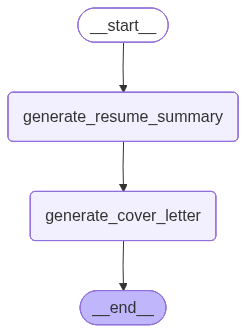

In [76]:
from IPython.display import Image, display

# Generate a visualization of the workflow graph
display(Image(app.get_graph().draw_mermaid_png()))

Now we are defining the input for the workflow by providing a job description, and then invoking the compiled app with this input to run the entire prompt chaining process.


In [77]:
input_state = {
        "job_description": "We are looking for a data scientist with experience in machine learning, NLP, and Python. Prior work with large datasets and experience deploying models into production is required."
}

result = app.invoke(input_state)

In [78]:
result['resume_summary']

'**Resume Summary:**\n\nResults-driven Data Scientist with extensive experience in machine learning and natural language processing (NLP). Proficient in Python and adept at handling large datasets, I have a proven track record of deploying robust models into production environments. Demonstrated ability to leverage analytical skills to drive business insights and optimize performance through data-driven strategies. Passionate about translating complex data into actionable solutions that enhance decision-making and operational efficiency.'

### Workflow Pattern: Routing

Routing is a pattern where an LLM (or small router agent) **classifies or interprets incoming input** and then **routes it to the appropriate sub-process** or agent. This design is helpful when you're dealing with **multiple types of tasks or user intents**, and you want specialized logic or handling for each case.

It works like a switchboard — one intelligent node (a classifier or router) analyzes the input and directs it to the correct branch.

#### Use Cases:
- AI customer service bots (route billing, tech support, or general inquiries)
- Multi-skill agents (for example, summarization, translation, and data extraction)
- Adaptive education bots (route to math, science, or grammar modules)

---

#### Routing Techniques:
1. **Hard-coded keyword-based routing** (primitive)
2. **LLM-based routing** using classification prompts
3. **Embedding-based semantic matching** with a routing map

---


### Use Case: Routing — Task Classifier for Summarization and Translation

In this workflow, we are going to build a simple **task router** using the Routing design pattern. The goal is to create a system that can intelligently decide whether the user wants to **summarize** or **translate** a given input, and then send it to the appropriate processing path.

This pattern is useful when the system needs to handle **multiple types of tasks** based on the user’s intent. Instead of creating one large model to handle everything, we let a **router node** classify the request and direct it to a **specialized sub-process**.

For example:
- If the input is “Summarize this article about AI,” the router sends it to the **summarizer**.
- If the input is “Translate this to French,” it sends it to the **translator**.


Now we are defining the `RouterState` using `TypedDict` to represent the shared state in our routing workflow. This state includes:

- `user_input`: the raw input provided by the user,
- `task_type`: the type of task determined by the router (for example, "summarize" or "translate"),
- `output`: the final result generated after routing to the appropriate task handler.


In [79]:
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

Now we are defining the `router_node`, which acts as the decision-maker in the workflow. It sends a prompt to the LLM asking it to classify the user's intent as either `"summarize"` or `"translate"`. The result is stored in the `task_type` field of the state and will determine which processing node the workflow routes to next.


In [80]:
class Router(BaseModel):
    role: str = Field(..., description="Decide whether the user wants to summarize a passage  ouput 'summarize'  or translate text into French oupput translate.")
llm_router=llm.bind_tools([Router])

In [81]:
response=llm_router.invoke("summarize this I love the sun its so warm")

In [82]:
def router_node(state: RouterState) -> RouterState:
    routing_prompt = f"""
    You are an AI task classifier.

    Decide whether the user wants to:
    - "summarize" a passage
    - or "translate" text into French

    Respond with just one word: 'summarize' or 'translate'.

    User Input: "{state['user_input']}"
    """

    response = llm_router.invoke(routing_prompt)

    return {**state, "task_type": response.tool_calls[0]['args']['role']} # This becomes the next node's name!

Now we are defining the `router` function, which simply returns the `task_type` from the state. This value will be used by LangGraph to decide which node to route to next based on the classification result.


In [83]:
def router(state: RouterState) -> str:
    return state['task_type']

Now we are defining the `summarize_node`, which is responsible for summarizing the user's input. It prompts the LLM to generate a concise summary and stores the result in the `output` field, while also confirming the `task_type` as `"summarize"`.


In [84]:
def summarize_node(state: RouterState) -> RouterState:
    prompt = f"Please summarize the following passage:\n\n{state['user_input']}"
    response = llm.invoke(prompt)

    return {**state, "task_type": "summarize", "output": response.content}

Now we are defining the `translate_node`, which handles translation tasks. It prompts the LLM to translate the user's input into French and saves the translated text in the `output` field, while also updating the `task_type` to `"translate"`.


In [85]:
def translate_node(state: RouterState) -> RouterState:
    prompt = f"Translate the following text to French:\n\n{state['user_input']}"
    response = llm.invoke(prompt)

    return {**state, "task_type": "translate", "output": response.content}

Now we are initializing a new `StateGraph` using the `RouterState` type. This sets up the structure of our routing workflow and defines the schema for the state that will be passed between nodes.


In [86]:
workflow = StateGraph(RouterState)


Now we are adding three nodes to the workflow:

- `"router"`: the node that classifies the user input,  
- `"summarize"`: the node that handles summarization,  
- `"translate"`: the node that handles translation.  


In [87]:
workflow.add_node("router", router_node)
workflow.add_node("summarize", summarize_node)
workflow.add_node("translate", translate_node)

Now we are setting `"router"` as the entry point of the workflow, meaning the execution will start by classifying the user’s intent.


In [88]:
workflow.set_entry_point("router")

Now we are adding conditional edges from the `"router"` node based on the value returned by the `router` function. If the task is `"summarize"`, the workflow routes to the `summarize` node; if it's `"translate"`, it routes to the `translate` node.


In [89]:
workflow.add_conditional_edges("router", router, {
    "summarize": "summarize",
    "translate": "translate"
})

Now we are marking both `"summarize"` and `"translate"` as valid finish points. This means the workflow can end after executing either node, depending on the task type selected by the router.


In [90]:
workflow.set_finish_point("summarize")
workflow.set_finish_point("translate")

We compile the workflow into an executable app using the `compile()` method. This step prepares the defined nodes and routing logic so the workflow can be run with actual input data.


In [91]:
app = workflow.compile()


To better understand the structure of our workflow, we use `app.get_graph().draw_png()` to generate a visual representation of the graph. This diagram helps us verify how nodes are connected and where conditional routing decisions lead within the workflow.


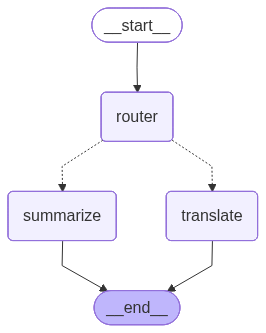

In [92]:
from IPython.display import Image, display

# Generate a visualization of the workflow graph
display(Image(app.get_graph().draw_mermaid_png()))

In this step, we provide a minimal input containing only the `user_input` field. Since the state is defined using `TypedDict`, missing fields such as `task_type` and `output` will be automatically handled during execution. We then invoke the app with this input, which starts the routing process and executes the appropriate task based on the user's intent.


In [93]:
input_text = {
        "user_input": "Can you translate this sentence: I love programming?"
    }

result = app.invoke(input_text)

In [94]:
print(result[ 'output'])
print(result['task_type'])

Sure! The translation of "I love programming" in French is "J'aime la programmation."
translate


Let's try the second task.


In [95]:
input_text = {
        "user_input": "Can you summarize this sentence: I love programming so much it is the best thing ever. All I want to do is programming?"
    }

result = app.invoke(input_text)

In [96]:
print(result[ 'output'])
print(result['task_type'])

The author expresses a deep passion for programming, considering it the best activity and their primary interest.
summarize


### Workflow Pattern: Parallelization

Parallelization is a pattern where **multiple LLM tasks are executed at the same time** instead of one after another. This is useful when different parts of the task can be done **independently**, allowing for faster processing and better system throughput.

Think of it like a kitchen where one chef is chopping vegetables, another is boiling pasta, and another is baking — all at once. None of them need to wait for the other to finish.

In AI workflows, this means breaking a problem into parts and running them **in parallel**, then collecting and combining the outputs.

#### Use Cases:
- Summarizing different sections of a large document simultaneously
- Translating a batch of user messages at once
- Generating multiple variations of an ad copy or product description
- Running safety checks using different prompts and comparing outputs
- Ensembling results from different models or prompts for consensus

---

#### Parallelization Techniques:
1. **Format Diversity (Multi-Output Tasks)**  
   - Run the **same input** through **different prompt styles, languages, or output formats**  
   - Each LLM call produces a distinct kind of result in parallel  
   - Combine all outputs into a unified response  
   - *Example:* Translate a sentence into French, Spanish, and Japanese at the same time

2. **Task Splitting (Sectioning)**  
   - Divide a large input into smaller parts  
   - Run each part through the same task (for example, summarization) in parallel  
   - Merge the partial results for a final outcome  
   - *Example:* Summarize each paragraph of an article simultaneously

3. **Consensus Voting (Multi-Agent Evaluation)**  
   - Run the **same task** multiple times with different agents or prompt styles  
   - Compare the responses and choose the best one via ranking or majority vote  
   - *Example:* Ask 3 variations of a model to write a safe response and pick the most appropriate one


### ⚡ Use Case: Parallelization — Multilingual Translation Assistant

In this workflow, we are building a **multilingual translation assistant** using the Parallelization design pattern. The goal is to take a single English sentence and generate its translations into **French**, **Spanish**, and **Japanese** — all at the same time.

Parallelization is ideal for this task because the translations are **independent of one another**. Since each language-specific translation can be processed separately, we can run them in **parallel** to save time and improve efficiency.

Once all translations are completed, we aggregate the outputs into a **single multilingual result**, making it easy to present or store all versions together.


To manage the data flowing through our parallel translation workflow, we define a `State` using `TypedDict`. This structure allows us to keep track of both the input and the individual outputs from each parallel task.

- `text`: stores the original English sentence to be translated
- `french`: will hold the French translation
- `spanish`: will hold the Spanish translation
- `japanese`: will hold the Japanese translation
- `combined_output`: will store the final combined result of all translations


In [97]:
class State(TypedDict):
    text: str
    french: str
    spanish: str
    japanese: str
    combined_output: str

Here, we define the `translate_french` node, which is responsible for translating the input text into French. It sends a prompt to the LLM asking for the French version of the input, and then stores the result in the `french` field of the state.


In [98]:
def translate_french(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to French:\n\n{state['text']}")
    return {"french": response.content.strip()}

In the same way, we define the `translate_spanish` node to handle translation into Spanish. It prompts the LLM with the input text and stores the translated result in the `spanish` field of the state.



In [99]:
def translate_spanish(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Spanish:\n\n{state['text']}")
    return {"spanish": response.content.strip()}

Similarly, we’ll create a `translate_japanese` node to translate the input text into Japanese and store the result in the `japanese` field.


In [100]:
def translate_japanese(state: State) -> dict:
    response = llm.invoke(f"Translate the following text to Japanese:\n\n{state['text']}")
    return {"japanese": response.content.strip()}

The `aggregator` node is responsible for combining the outputs from all three translation nodes into a single, readable format. It constructs a formatted string that includes the original text along with its French, Spanish, and Japanese translations, and stores the final result in the `combined_output` field.


In [101]:
def aggregator(state: State) -> dict:
    combined = f"Original Text: {state['text']}\n\n"
    combined += f"French: {state['french']}\n\n"
    combined += f"Spanish: {state['spanish']}\n\n"
    combined += f"Japanese: {state['japanese']}\n"
    return {"combined_output": combined}

We initialize a new `StateGraph` using the `State` type. This sets up the foundation for our parallel workflow and defines the structure of the data that will flow between nodes.


In [102]:
graph = StateGraph(State)

We add four nodes to the graph:

- `"translate_french"`: handles translation to French,  
- `"translate_spanish"`: handles translation to Spanish,  
- `"translate_japanese"`: handles translation to Japanese,  
- `"aggregator"`: collects and combines all translations into one output.

Each of these nodes will operate independently before merging at the aggregator.


In [103]:
graph.add_node("translate_french", translate_french)
graph.add_node("translate_spanish", translate_spanish)
graph.add_node("translate_japanese", translate_japanese)
graph.add_node("aggregator", aggregator)

We connect the three translation nodes to the `START` of the workflow. This means all translation tasks will begin simultaneously in parallel as soon as the workflow is triggered.


In [104]:
# Connect parallel nodes from START
graph.add_edge(START, "translate_french")
graph.add_edge(START, "translate_spanish")
graph.add_edge(START, "translate_japanese")

Here, we connect each of the translation nodes to the `aggregator` node. Once all translations are complete, their outputs will be passed to the aggregator to be combined into the final result.


In [105]:
# Connect all translation nodes to the aggregator
graph.add_edge("translate_french", "aggregator")
graph.add_edge("translate_spanish", "aggregator")
graph.add_edge("translate_japanese", "aggregator")

We connect the `aggregator` node to the `END` of the workflow, marking it as the final step where the combined output is returned.


In [106]:
# Final node
graph.add_edge("aggregator", END)

In [107]:
# Compile the graph
app = graph.compile()

We provide an English sentence as input under the `text` field and invoke the workflow. This triggers all translation tasks in parallel, and once completed, the translations are combined and returned as the final result.


In [108]:
input_text = {
        "text": "Good morning! I hope you have a wonderful day."
}

result = app.invoke(input_text)

In [109]:
result

{'text': 'Good morning! I hope you have a wonderful day.',
 'french': "Bonjour ! J'espère que vous passerez une journée merveilleuse.",
 'spanish': '¡Buenos días! Espero que tengas un día maravilloso.',
 'japanese': 'おはようございます！素晴らしい一日をお過ごしください。',
 'combined_output': "Original Text: Good morning! I hope you have a wonderful day.\n\nFrench: Bonjour ! J'espère que vous passerez une journée merveilleuse.\n\nSpanish: ¡Buenos días! Espero que tengas un día maravilloso.\n\nJapanese: おはようございます！素晴らしい一日をお過ごしください。\n"}

### Exercises: Building a Multi-Agent Routing System


#### Exercise 1 - Create State Management and Router Tool
Define the state structure and classification tool for your multi-agent routing system. You need to create a TypedDict for state management and a Pydantic model for LLM tool binding.

Your task: Create the foundational components for routing between ride hailing, restaurant orders, groceries, and default handling.


<details>
    <summary>Click here for the solution</summary>

```python

class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

class Router(BaseModel):
    role: str = Field(
        ...,
        description="Classify the user request. Return exactly one of: 'ride_hailing_call', 'restaurant_order', 'groceries' and if you do not know output 'default_handler'"
    )

llm_router = llm.bind_tools([Router])

```

</details>


In [110]:
# TODO: Define your RouterState TypedDict with three fields
# TODO: Create a Router BaseModel with proper field description
# TODO: Bind the router tool to your LLM
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str

class Router(BaseModel):
    role: str = Field(
        ...,
        description="Classify the user request. Return exactly one of: 'ride_hailing_call', 'restaurant_order', 'groceries' and if you do not know output 'default_handler'"
    )

llm_router = llm.bind_tools([Router])


#### Exercise 2 - Implement Router Logic

Create the router node function that classifies user input and handles cases where the LLM doesn't return a tool call. Also implement the router decision function.

Your task: Build the classification logic with proper error handling for unclassified requests.


<details>
    <summary>Click here for the solution</summary>

```python

def router_node(state: RouterState) -> RouterState:
    response = llm_router.invoke(state['user_input'])
    
    if response.tool_calls:
        tool_call = response.tool_calls[0]['args']['role']
        return {**state, "task_type": tool_call}
    else:
        return {**state, "task_type": "default_handler"}

def router(state: RouterState) -> str:
    return state['task_type']

```

</details>


In [111]:
# TODO: Implement router_node function with tool call handling
# TODO: Add fallback to "default_handler" when no tool calls
# TODO: Create router function that returns task_type from state
def router_node(state: RouterState) -> RouterState:
    response = llm_router.invoke(state['user_input'])

    if response.tool_calls:
        tool_call = response.tool_calls[0]['args']['role']
        return {**state, "task_type": tool_call}
    else:
        return {**state, "task_type": "default_handler"}

def router(state: RouterState) -> str:
    return state['task_type']

In [112]:
def ride_hailing_node(state: RouterState) -> RouterState:
    """
    Processes ride hailing requests by extracting pickup/dropoff locations and preferences
    """
    prompt = f"""
    You are a ride hailing assistant. Based on the user's request, extract and organize the following information:

    - Pickup location
    - Destination/dropoff location
    - Preferred ride type (if mentioned)
    - Any special requirements
    - Estimated timing preferences

    User Request: "{state['user_input']}"

    Provide a clear summary of the ride request with all available details.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "ride_hailing_call",
        "output": response.content.strip()
    }

def restaurant_order_node(state: RouterState) -> RouterState:
    """
    Processes restaurant orders by organizing menu items, quantities, and preferences
    """
    prompt = f"""
    You are a restaurant ordering assistant. Based on the user's request, organize the following information:

    - Menu items requested
    - Quantities for each item
    - Special modifications or dietary restrictions
    - Delivery or pickup preference
    - Any timing requirements

    User Request: "{state['user_input']}"

    Provide a clear, organized summary of the restaurant order with all details.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "restaurant_order",
        "output": response.content.strip()
    }

def groceries_node(state: RouterState) -> RouterState:
    """
    Processes grocery delivery requests with driver pickup service
    """
    prompt = f"""
    You are a grocery delivery assistant for a service where our drivers pick up groceries for customers.

    Based on the user's request, organize the following information:

    Shopping List:
    - List of grocery items needed
    - Quantities or amounts for each item
    - Brand preferences (if mentioned)
    - Any dietary restrictions or organic preferences

    Store Information:
    - Preferred store or location
    - Budget considerations
    - Special instructions for finding items

    Delivery Details:
    - Delivery address (if provided)
    - Preferred delivery time window
    - Any special delivery instructions
    - Contact information for driver coordination

    Driver Instructions:
    - Substitution preferences (if item unavailable)
    - How to handle out-of-stock items
    - Any items requiring special handling (fragile, cold items)
    - Payment method (if mentioned)

    User Request: "{state['user_input']}"

    Provide a comprehensive delivery order summary that our driver can use to efficiently shop and deliver groceries.
    Include estimated pickup time and any special notes for the shopping trip.

    Format the response as a clear, organized delivery order that includes all necessary details for our driver service.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "groceries",
        "output": response.content.strip()
    }
def default_handler_node(state: RouterState) -> RouterState:
    prompt = f"""
    I couldn't classify your request into a specific category.
    Let me provide general assistance for: "{state['user_input']}"

    I can help you with:
    - Ride hailing services
    -  Restaurant orders
    -  Grocery shopping

    Please rephrase your request to match one of these services, or if you need assistance with something else, I will connect you with our customer support team who can provide personalized help.

    Would you like me to:
    1. Help you rephrase your request for one of our services
    2. Connect you with customer support for additional assistance
    """
    response = llm.invoke(prompt)
    return {**state, "task_type": "default_handler", "output": response.content.strip()}


#### Exercise 3 - Assemble the Complete Workflow

Put all the pieces together by building the StateGraph, adding nodes, setting up routing logic, and compiling the application.

Your task: Create the complete workflow graph with proper routing and finish points, and call it ```app```.


<details>
    <summary>Click here for the solution</summary>

```python
workflow = StateGraph(RouterState)

# Add all nodes
workflow.add_node("router", router_node)
workflow.add_node("ride_hailing_call", ride_hailing_node)
workflow.add_node("restaurant_order", restaurant_order_node)
workflow.add_node("groceries", groceries_node)
workflow.add_node("default_handler", default_handler_node)

# Set entry point
workflow.set_entry_point("router")

# Add conditional routing
workflow.add_conditional_edges("router", router, {
    "groceries": "groceries",
    "restaurant_order": "restaurant_order",
    "ride_hailing_call": "ride_hailing_call",
    "default_handler": "default_handler"
})

# Set finish points
workflow.set_finish_point("ride_hailing_call")
workflow.set_finish_point("restaurant_order")
workflow.set_finish_point("groceries")
workflow.set_finish_point("default_handler")

# Compile the application
app = workflow.compile()

```

</details>


In [113]:
# TODO: Create StateGraph with RouterState
# TODO: Add all five nodes (router + 4 processing nodes)
# TODO: Set router as entry point
# TODO: Add conditional edges with all four routing options
# TODO: Set finish points for all processing nodes
# TODO: Compile the application
workflow = StateGraph(RouterState)
# Add all nodes
workflow.add_node("router", router_node)
workflow.add_node("ride_hailing_call", ride_hailing_node)
workflow.add_node("restaurant_order", restaurant_order_node)
workflow.add_node("groceries", groceries_node)
workflow.add_node("default_handler", default_handler_node)

# Set entry point
workflow.set_entry_point("router")

# Add conditional routing
workflow.add_conditional_edges("router", router, {
    "groceries": "groceries",
    "restaurant_order": "restaurant_order",
    "ride_hailing_call": "ride_hailing_call",
    "default_handler": "default_handler"
})

# Set finish points
workflow.set_finish_point("ride_hailing_call")
workflow.set_finish_point("restaurant_order")
workflow.set_finish_point("groceries")
workflow.set_finish_point("default_handler")

# Compile the application
app = workflow.compile()

Test your implementation here:


In [114]:
test_cases = [
    {"user_input": "I need a ride from downtown to the airport at 3pm"},
    {"user_input": "I want to order 2 large pepperoni pizzas for delivery"},
    {"user_input": "I need milk, bread, eggs, and vegetables for the week"},
    {"user_input": "What's the weather like today?"},  # Default/unclassified example
]

for i, test_input in enumerate(test_cases, 1):
    result=app.invoke(test_input)


    print(f"question {test_input['user_input']}\n")
    print(f"task_type {result['task_type']}\n")
    print(f"output: {result['output']}\n")
    print('-----------------------------------')

question I need a ride from downtown to the airport at 3pm

task_type ride_hailing_call

output: **Ride Request Summary:**

- **Pickup Location:** Downtown
- **Destination/Dropoff Location:** Airport
- **Preferred Ride Type:** Not mentioned
- **Special Requirements:** None specified
- **Estimated Timing Preferences:** 3 PM

-----------------------------------
question I want to order 2 large pepperoni pizzas for delivery

task_type restaurant_order

output: ### Order Summary

- **Menu Items Requested:**
  - 2 Large Pepperoni Pizzas

- **Quantities:**
  - Large Pepperoni Pizzas: 2

- **Special Modifications or Dietary Restrictions:**
  - None specified

- **Delivery or Pickup Preference:**
  - Delivery

- **Timing Requirements:**
  - None specified

This order includes two large pepperoni pizzas for delivery, with no special modifications or dietary restrictions noted.

-----------------------------------
question I need milk, bread, eggs, and vegetables for the week

task_type grocerie

Here is the complete code:


In [115]:
class RouterState(TypedDict):
    user_input: str
    task_type: str
    output: str


class Router(BaseModel):
    role: str = Field(
        ...,
        description="Classify the user request. Return exactly one of: 'ride_hailing_call', 'restaurant_order',  'groceries' and if you do not know output  'default_handler'"
    )

llm_router = llm.bind_tools([Router])

def router_node(state: RouterState) -> RouterState:
    response = llm_router.invoke(state['user_input'])

    if response.tool_calls:
        tool_call = response.tool_calls[0]['args']['role']
        return {**state, "task_type": tool_call}
    else:
        return {**state, "task_type": "default_handler"}


def router(state: RouterState) -> str:
    return state['task_type']

def ride_hailing_node(state: RouterState) -> RouterState:
    """
    Processes ride hailing requests by extracting pickup/dropoff locations and preferences
    """
    prompt = f"""
    You are a ride hailing assistant. Based on the user's request, extract and organize the following information:

    - Pickup location
    - Destination/dropoff location
    - Preferred ride type (if mentioned)
    - Any special requirements
    - Estimated timing preferences

    User Request: "{state['user_input']}"

    Provide a clear summary of the ride request with all available details.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "ride_hailing_call",
        "output": response.content.strip()
    }

def restaurant_order_node(state: RouterState) -> RouterState:
    """
    Processes restaurant orders by organizing menu items, quantities, and preferences
    """
    prompt = f"""
    You are a restaurant ordering assistant. Based on the user's request, organize the following information:

    - Menu items requested
    - Quantities for each item
    - Special modifications or dietary restrictions
    - Delivery or pickup preference
    - Any timing requirements

    User Request: "{state['user_input']}"

    Provide a clear, organized summary of the restaurant order with all details.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "restaurant_order",
        "output": response.content.strip()
    }

def groceries_node(state: RouterState) -> RouterState:
    """
    Processes grocery delivery requests with driver pickup service
    """
    prompt = f"""
    You are a grocery delivery assistant for a service where our drivers pick up groceries for customers.

    Based on the user's request, organize the following information:

    Shopping List:
    - List of grocery items needed
    - Quantities or amounts for each item
    - Brand preferences (if mentioned)
    - Any dietary restrictions or organic preferences

    Store Information:
    - Preferred store or location
    - Budget considerations
    - Special instructions for finding items

    Delivery Details:
    - Delivery address (if provided)
    - Preferred delivery time window
    - Any special delivery instructions
    - Contact information for driver coordination

    Driver Instructions:
    - Substitution preferences (if item unavailable)
    - How to handle out-of-stock items
    - Any items requiring special handling (fragile, cold items)
    - Payment method (if mentioned)

    User Request: "{state['user_input']}"

    Provide a comprehensive delivery order summary that our driver can use to efficiently shop and deliver groceries.
    Include estimated pickup time and any special notes for the shopping trip.

    Format the response as a clear, organized delivery order that includes all necessary details for our driver service.
    """

    response = llm.invoke(prompt)

    return {
        **state,
        "task_type": "groceries",
        "output": response.content.strip()
    }
def default_handler_node(state: RouterState) -> RouterState:
    prompt = f"""
    I couldn't classify your request into a specific category.
    Let me provide general assistance for: "{state['user_input']}"

    I can help you with:
    - Ride hailing services
    -  Restaurant orders
    -  Grocery shopping

    Please rephrase your request to match one of these services, or if you need assistance with something else, I will connect you with our customer support team who can provide personalized help.

    Would you like me to:
    1. Help you rephrase your request for one of our services
    2. Connect you with customer support for additional assistance
    """
    response = llm.invoke(prompt)
    return {**state, "task_type": "default_handler", "output": response.content.strip()}

workflow = StateGraph(RouterState)
workflow.add_node("ride_hailing_call", ride_hailing_node)
workflow.add_node("restaurant_order", restaurant_order_node)
workflow.add_node("groceries", groceries_node)
workflow.add_node("default_handler", default_handler_node)
workflow.add_node("router", router_node)
workflow.set_entry_point("router")
# Update your conditional edges to route to all three options
workflow.add_conditional_edges("router", router, {"groceries":"groceries", "restaurant_order":"restaurant_order","ride_hailing_call":"ride_hailing_call","default_handler":"default_handler"})


# Set all three as possible finish points

workflow.set_finish_point("ride_hailing_call")
workflow.set_finish_point("restaurant_order")
workflow.set_finish_point("groceries")

app = workflow.compile()

test_cases = [
    {"user_input": "I need a ride from downtown to the airport at 3pm"},
    {"user_input": "I want to order 2 large pepperoni pizzas for delivery"},
    {"user_input": "I need milk, bread, eggs, and vegetables for the week"},
    {"user_input": "What's the weather like today?"},  # Default/unclassified example
]

for i, test_input in enumerate(test_cases, 1):
    result=app.invoke(test_input)


    print(f"question {test_input['user_input']}\n")
    print(f"task_type {result['task_type']}\n")
    print(f"output: {result['output']}\n")
    print('-----------------------------------')

question I need a ride from downtown to the airport at 3pm

task_type ride_hailing_call

output: **Ride Request Summary:**

- **Pickup Location:** Downtown
- **Destination/Dropoff Location:** Airport
- **Preferred Ride Type:** Not mentioned
- **Special Requirements:** None mentioned
- **Estimated Timing Preferences:** 3 PM

-----------------------------------
question I want to order 2 large pepperoni pizzas for delivery

task_type restaurant_order

output: ### Restaurant Order Summary

- **Menu Items Requested:**
  - Large Pepperoni Pizzas

- **Quantities:**
  - 2

- **Special Modifications or Dietary Restrictions:**
  - None specified

- **Delivery or Pickup Preference:**
  - Delivery

- **Timing Requirements:**
  - None specified

Please confirm if you would like to add any additional details!

-----------------------------------
question I need milk, bread, eggs, and vegetables for the week

task_type groceries

output: ### Delivery Order Summary

---

**Shopping List:**
- **Items 